Fourier Amplitude Correlation: 0.96
Fourier Phase Correlation: 0.07


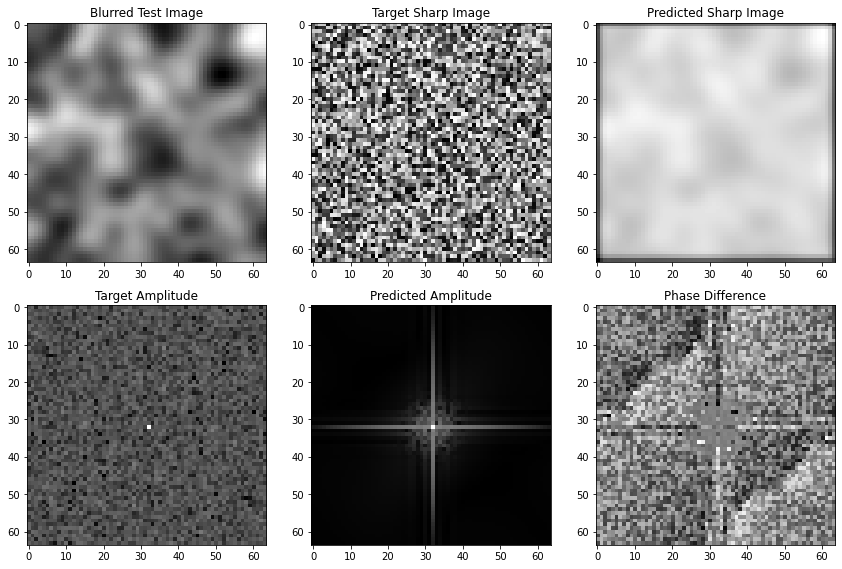

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# CUDA VISIBLE DEVICES=0
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from scipy.fft import fft2, fftshift
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError


# Generating synthetic sharp and blurred images for training
def create_synthetic_images(num_images=100, image_size=64, blur_sigma=3):
    sharp_images = np.random.rand(num_images, image_size, image_size, 1)
    blurred_images = np.array([gaussian_blur(image, sigma=blur_sigma) for image in sharp_images])
    return blurred_images, sharp_images

# Simple Gaussian blur function
def gaussian_blur(image, sigma=3):
    from scipy.ndimage import gaussian_filter
    return gaussian_filter(image, sigma=sigma)

# Generate synthetic data
blurred_images, sharp_images = create_synthetic_images()
X_train, X_test, y_train, y_test = train_test_split(blurred_images, sharp_images, test_size=0.2, random_state=42)

# Defining a simple CNN for sharpening
model = Sequential([
    InputLayer(input_shape=(64, 64, 1)),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(1, (3, 3), activation='linear', padding='same')  # Output layer for sharpening
])
model.compile(optimizer=Adam(), loss=MeanSquaredError())

# Training the model
history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_split=0.1, verbose=0)

# Predicting on a test image
test_image = X_test[0]
predicted_image = model.predict(test_image[np.newaxis, ...])[0]

# Fourier analysis - calculating amplitude and phase for target and predicted images
def calculate_fourier_amplitude_phase(image):
    fft_image = fft2(image.squeeze())
    fft_shifted = fftshift(fft_image)
    amplitude = np.abs(fft_shifted)
    phase = np.angle(fft_shifted)
    return amplitude, phase

# Calculate Fourier amplitude and phase for target and prediction
target_amplitude, target_phase = calculate_fourier_amplitude_phase(y_test[0])
predicted_amplitude, predicted_phase = calculate_fourier_amplitude_phase(predicted_image)

# Fourier shell correlation function
def fourier_shell_correlation(amplitude1, phase1, amplitude2, phase2):
    amplitude_correlation = np.corrcoef(amplitude1.ravel(), amplitude2.ravel())[0, 1]
    phase_correlation = np.corrcoef(phase1.ravel(), phase2.ravel())[0, 1]
    return amplitude_correlation, phase_correlation

# Calculating the Fourier amplitude and phase correlations
amplitude_corr, phase_corr = fourier_shell_correlation(target_amplitude, target_phase, predicted_amplitude, predicted_phase)

# Displaying the results
print(f"Fourier Amplitude Correlation: {amplitude_corr:.2f}")
print(f"Fourier Phase Correlation: {phase_corr:.2f}")

# Displaying the test, predicted, and Fourier-transformed images
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax[0, 0].imshow(test_image.squeeze(), cmap='gray')
ax[0, 0].set_title("Blurred Test Image")

ax[0, 1].imshow(y_test[0].squeeze(), cmap='gray')
ax[0, 1].set_title("Target Sharp Image")

ax[0, 2].imshow(predicted_image.squeeze(), cmap='gray')
ax[0, 2].set_title("Predicted Sharp Image")

ax[1, 0].imshow(np.log(1 + target_amplitude), cmap='gray')
ax[1, 0].set_title("Target Amplitude")

ax[1, 1].imshow(np.log(1 + predicted_amplitude), cmap='gray')
ax[1, 1].set_title("Predicted Amplitude")

ax[1, 2].imshow(target_phase - predicted_phase, cmap='gray')
ax[1, 2].set_title("Phase Difference")

plt.tight_layout()
plt.show()

